# Logistic regression model building
Here we will construct our first model. It is a very simple one: a logistic regression.

We will follow the following scheme:
    1. Discrimination: we will discard some users based on how much time has passed since they bought their last product and we will set the products that our classifier will have to predict.
    2. Classifier input: we will construct the input as it is passed to the regression.
    3. Model construction: we train the classifier and compute its accuracy.
    4. Implementation: Brief comment about drawbacks.

In [1]:
import numpy as np
import pandas as pd
import time

In [2]:
data = pd.read_csv('train2.txt',sep='|')

In [3]:
data2 = data.copy(deep=True)
data2['Year'] = data2.Cod_Fecha.apply(lambda x: x[:4])
data2['Month'] = data2.Cod_Fecha.apply(lambda x: x[-2:])
data2.head()

,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Year,Month
0,A0000001,601,2007-05,5,4,3,1,0,2007,05
1,A0000001,704,2013-04,5,4,3,1,0,2013,04
2,A0000001,2501,2006-03,5,4,3,1,0,2006,03
3,A0000001,2503,2006-03,5,4,3,1,0,2006,03
4,A0000001,1011,2011-04,5,4,3,1,0,2011,04


# 1. Discrimination: we consider only the last N years (when most products are available)
So, our model will not be affected by clients with products bought many years ago, when the possible products were fewer.

In [4]:
N_YEARS=2017-1990

In [5]:
dataLastN = data2.copy(deep=True)
dataLastN.Year = dataLastN.Year.astype(int)
dataLastN = dataLastN[dataLastN.Year >= 2017-N_YEARS]

#### We will be using a supervised classifier, so we have to divide the data into an input part and a *"true response"* (say the last product a customer has bought). Of course, to be consistent with our line of reasoning, this last purchase should be relatively recent.

In [6]:
#Sort data by date and find most recent product of every customer
dataLastN.sort_values(by='Cod_Fecha',inplace=True)
idAndLastProd = dataLastN.groupby('ID_Customer').last()
idAndLastProd.head()

,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Year,Month
ID_Customer,,,,,,,,,
A0000001,704,2013-04,5,4,3,1,0,2013,04
A0000002,9992,2015-02,5,5,1,1,0,2015,02
A0000003,201,2016-02,5,5,5,2,0,2016,02
A0000004,2301,2016-05,5,5,3,1,0,2016,05
A0000006,2302,2015-05,5,5,3,1,0,2015,05


Here is where we defined our notio of "recent". We will consider recent a product purchased in the last 5 years, that is, from 2012 onwards. We compute also how many clients are we loosing after this filtering.

In [7]:
YEARS_LAST_PRODUCT = 5

In [9]:
print 'Clients with older products (they fall out of the classifier):', idAndLastProd[idAndLastProd.Year < 2017 - YEARS_LAST_PRODUCT].shape[0], idAndLastProd[idAndLastProd.Year < 2017 - YEARS_LAST_PRODUCT].shape[0]/float(idAndLastProd.shape[0])*100, '%'
print 'Clients with recent products:', idAndLastProd[idAndLastProd.Year >= 2017 - YEARS_LAST_PRODUCT].shape[0], idAndLastProd[idAndLastProd.Year >= 2017 - YEARS_LAST_PRODUCT].shape[0]/float(idAndLastProd.shape[0])*100, '%'

Clients with older products (they fall out of the classifier): 148053 22.0921869404 %
Clients with recent products: 522107 77.9078130596 %


In [10]:
#So, the clients we will be using are selected. As clients supervised
clients_sup = idAndLastProd[idAndLastProd.Year >= 2017 - YEARS_LAST_PRODUCT].index.values
clients_unsup = idAndLastProd[idAndLastProd.Year < 2017 - YEARS_LAST_PRODUCT].index.values

In [11]:
#Returns the dataframe with the corresponding clients
def selectClients(data,clients):
    #df is a dataframe
    #clients is an array of strings
    df = pd.DataFrame(columns=data.columns.values)
    df = data[data.ID_Customer.isin(clients)]
    
    return df

In [12]:
data_sup = selectClients(dataLastN,clients_sup)
print data_sup.shape, data_sup.ID_Customer.unique().size
data_unsup = selectClients(dataLastN,clients_unsup)
print data_unsup.shape, data_unsup.ID_Customer.unique().size

(2935685, 10) 522107
(361939, 10) 148053


At this point, we have a new dataframe with 2.935.685 rows and 522.107 clients. This will be our input in the classifier.

----------------------------------------------------------------------------------------------------------------------

## 2. Classifier input: ID_Customer vs Products in last N years.
In this section, we prepare all the information stored in the dataframe in a convenient way for our regression.

In [13]:
#Initialize the matrix ID_Customer vs. Product ID
colnames = data_sup.Cod_Prod.unique()
colnames.sort()
rownames = data_sup.ID_Customer.unique()
rownames.sort()
idVSProdLastN = pd.DataFrame(data=np.zeros((rownames.size,colnames.size)),columns=colnames,index=rownames,dtype=int)

We select now the product list for every user and subtract the last one, which will be the value that our classifier will have to predict.

In [19]:
groupedDataLastN = data_sup.groupby(['ID_Customer','Cod_Prod'])['Cod_Prod'].count()
groupedDataLastN.head(10)

ID_Customer  Cod_Prod
A0000001     601         1
             704         1
             1011        1
             2501        1
             2503        1
A0000002     301         1
             601         1
             801         1
             9992        1
A0000003     201         1
Name: Cod_Prod, dtype: int64

In [17]:
lastProduct = data_sup.groupby('ID_Customer')['Cod_Prod'].last()
lastProduct.head()

ID_Customer
A0000001     704
A0000002    9992
A0000003     201
A0000004    2301
A0000006    2302
Name: Cod_Prod, dtype: int64

We put the last product to 0 in groupedDataLastN.

In [20]:
groupedDataLastN.loc[zip(lastProduct.index.values,lastProduct.values)] = 0
groupedDataLastN.head(10)

ID_Customer  Cod_Prod
A0000001     601         1
             704         0
             1011        1
             2501        1
             2503        1
A0000002     301         1
             601         1
             801         1
             9992        0
A0000003     201         0
Name: Cod_Prod, dtype: int64

In [21]:
#Save data on matrix
for product in groupedDataLastN.index.levels[1].values:
    columna = groupedDataLastN[:,product]
    idVSProdLastN.loc[columna.index,product] = columna.values
idVSProdLastN.head()

,101,102,103,104,201,301,502,503,504,506,...,2706,2707,2801,2901,3001,3101,3401,9991,9992,9993
A0000001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0000002,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0000003,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0000004,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0000006,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


----------------------------------------------------------------------------------------------------------------------

Let's add also the customer's socio-demographic coefficients. We will introduce them using one-hot encoding.

In [22]:
#Customer features
customers = data_sup.groupby('ID_Customer')['Socio_Demo_01','Socio_Demo_02','Socio_Demo_03','Socio_Demo_04','Socio_Demo_05'].first()
customers[:5]

,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05
ID_Customer,,,,,
A0000001,5,4,3,1,0
A0000002,5,5,1,1,0
A0000003,5,5,5,2,0
A0000004,5,5,3,1,0
A0000006,5,5,3,1,0


In [23]:
#New rows
idVSProdLastN['Socio_Demo_01_1'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_01_2'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_01_3'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_01_4'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_01_5'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_02_1'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_02_2'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_02_3'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_02_4'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_02_5'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_03_1'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_03_2'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_03_3'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_03_4'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_03_5'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_04_1'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_04_2'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_05_1'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_05_2'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_05_3'] = np.zeros(idVSProdLastN.shape[0],dtype=int)
idVSProdLastN['Socio_Demo_05_4'] = np.zeros(idVSProdLastN.shape[0],dtype=int)

In [24]:
socioDemoCol = ['Socio_Demo_01_1','Socio_Demo_01_2','Socio_Demo_01_3','Socio_Demo_01_4','Socio_Demo_01_5','Socio_Demo_02_1','Socio_Demo_02_2','Socio_Demo_02_3','Socio_Demo_02_4','Socio_Demo_02_5','Socio_Demo_03_1','Socio_Demo_03_2','Socio_Demo_03_3','Socio_Demo_03_4','Socio_Demo_03_5','Socio_Demo_04_1','Socio_Demo_04_2','Socio_Demo_05_1','Socio_Demo_05_2','Socio_Demo_05_3','Socio_Demo_05_4']

In [25]:
#We add 1 to Socio_Demo_05 in order to compute one hot encoding for our convenience. It is easier to compute in this way.
customers.Socio_Demo_05 += 1

We add these features to the previous matrix, in one-hot encoding format.

In [26]:
#Introduce one-hot encoding to matrix.
start = 94
i = 0
for ncols in np.array([5,5,5,2,4]):
    idVSProdLastN.iloc[:,start:start+ncols] = pd.get_dummies(customers.values[:,i]).values
    start += ncols
    i += 1

The result is shown below: a 522107 times 115 matrix.

In [27]:
idVSProdLastN.head()

,101,102,103,104,201,301,502,503,504,506,...,Socio_Demo_03_2,Socio_Demo_03_3,Socio_Demo_03_4,Socio_Demo_03_5,Socio_Demo_04_1,Socio_Demo_04_2,Socio_Demo_05_1,Socio_Demo_05_2,Socio_Demo_05_3,Socio_Demo_05_4
A0000001,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
A0000002,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
A0000003,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
A0000004,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
A0000006,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0


----------------------------------------------------------------------------------------------------------------------

# 3. Model construction. Logistic Regression.
### We create a multinomial logistic regression which gives probabilities for every product to be bought.

In [30]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
logist_reg = LogisticRegression

Notice that we have only 87 of the original 94 products in the prediction set. This will set a bound for the accuray of our classifier, since it will be "punished" whenever it predicts any of the remaining 7 products.

In [28]:
print 'N. of products: ', lastProduct.unique().size
print lastProduct.value_counts().tail(10)

N. of products:  87
1008    4
804     3
1014    2
1004    2
1305    2
1015    2
803     1
1308    1
2901    1
2703    1
Name: Cod_Prod, dtype: int64


Notice also that some of this products appear very few and this will be a drawback when predicting this kind of products. There are few examples to learn from.

In [32]:
start_time = time.time()
train_size = idVSProdLastN.shape[0]/1000
x_train = idVSProdLastN[:train_size]
y_train = lastProduct[:train_size]
x_test = idVSProdLastN[-train_size:]
y_test = lastProduct[-train_size:]
logist_reg = LogisticRegression(C=1e5,multi_class='multinomial',solver='newton-cg')
logist_reg.fit(x_train,y_train)
print 'Time:', time.time()-start_time
print 'Score (R square):', logist_reg.score(x_test,y_test)*100, '%'
print 'Training MSE: ', np.mean((logist_reg.predict(x_train) - y_train)**2)
print 'Test MSE: ', np.mean((logist_reg.predict(x_test) - y_test)**2)

Time: 20.4381299019
Score (R square): 0.304597701149


/Users/Victor/anaconda/lib/python2.7/site-packages/sklearn/utils/optimize.py:200: UserWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [33]:
#We save the model, for future use, so we do not need to train it again.
from sklearn.externals import joblib
joblib.dump(logist_reg, 'logisticCajamar.pkl')

['logistic910.pkl',
 'logistic910.pkl_01.npy',
 'logistic910.pkl_02.npy',
 'logistic910.pkl_03.npy',
 'logistic910.pkl_04.npy']

In [34]:
#Recovering the model from file
logistic910 = joblib.load('logisticCajamar.pkl') 

Since our model gives probabilities as a result, we can obtain the 3 most probable products for a customer. For exampel, for customer

In [36]:
x_test[:1].index[0]

'A0675746'

the most probable products are

In [80]:
a= logist_reg.predict_proba(x_test[:1])[0]
b = y_train.unique()
b.sort()
ab = pd.Series(data=a,index=b)
ab.nlargest(3)

704     1.000000e+00
301     1.392967e-09
2302    5.669144e-10
dtype: float64

The confusion matrix is the following:

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,logist_reg.predict(x_test))

array([[21,  1,  0, ...,  0,  1,  0],
       [ 1,  0,  0, ...,  0,  1,  0],
       [ 4,  0, 47, ...,  0,  0,  0],
       ..., 
       [ 1,  0,  0, ..., 24,  0,  0],
       [ 1,  0,  0, ...,  0,  4,  0],
       [ 0,  0,  0, ...,  0,  0, 23]])

After normalization, this yields:

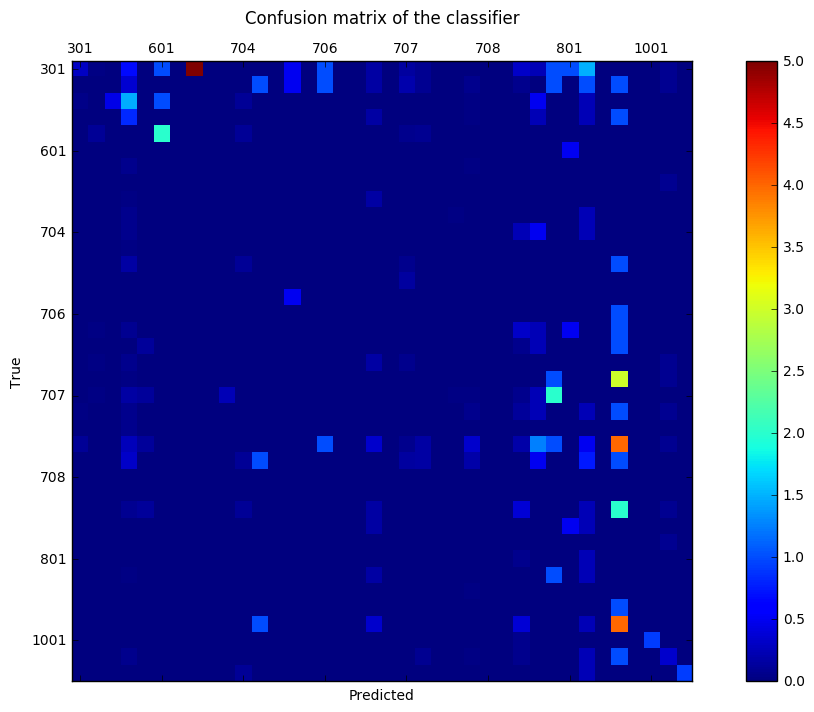

In [61]:
import matplotlib.pyplot as plt
labels = y_test.unique()
labels.sort()
pred = logist_reg.predict(x_test)
cm = confusion_matrix(y_test, pred, labels)
cm = cm/cm.astype(np.float).sum(axis=1)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
fig.set_size_inches((14,8))
plt.show()

This model is however not very powerful and has low accuracy, that is why we decided to test a neural network. Which is explained in a companion Notebook.

----------------------------------------------------------------------------------------------------------------------

# 4. Implementation

This model is easy to implement and the major drawbacks it could have are its low accuracy and the fact that, if one desires to improve the model by training it with more data, it must be trained from the beginning and depending on the amount of data and the processing speed of the computer it can be a costly procedure.